In [2]:
import jax
import tensorflow as tf
import ml_collections
import numpy as np
import os

2023-04-26 20:39:11.727589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/extras/CUPTI/lib64
2023-04-26 20:39:11.728236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/extras/CUPTI/lib64
2023-04-26 20:39:11.728240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
IMAGE_WIDTH  = 240
IMAGE_HEIGHT = 320

# IMAGE_WIDTH_RESIZE = 240
# IMAGE_HEIGHT_RESIZE = 320

NUM_VERTEX = 7306

In [4]:
config = ml_collections.ConfigDict()
config.model = 'Classic_CNN'
config.dataset = 'multiface'
config.image_size = (240, 320)
config.num_epochs = 200
config.warmup_epochs = 10
config.batch_size = 1
config.learning_rate = 0.0001
config.log_every_steps = 1
config.vertex = 7306
config.num_train_steps = -1

In [5]:
def readTFRECORD(tfrecord_pth: str,
                 config: ml_collections.ConfigDict) -> tf.data:
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    data_set = tf.data.TFRecordDataset(tfrecord_pth)
    # data_set = data_set.repeat()
    data_set = data_set.map(parse, num_parallel_calls=AUTOTUNE)

    # data_set = data_set.shuffle(config.batch_size * 16,
    #                             reshuffle_each_iteration=True)
    data_batch = data_set.batch(config.batch_size, drop_remainder=True)
    data_batch = data_batch.prefetch(buffer_size=AUTOTUNE)
    return data_batch


def parse(example_proto):
    features = tf.io.parse_single_example(example_proto,
                                          features={
                                              'img':
                                              tf.io.FixedLenFeature([],
                                                                    tf.string),
                                              'vtx':
                                              tf.io.FixedLenFeature([],
                                                                    tf.string)
                                          })

    img = features['img']
    vtx = features['vtx']

    img = tf.io.decode_raw(img, np.float32)
    vtx = tf.io.decode_raw(vtx, np.float32)

    img = tf.reshape(img, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    vtx = tf.reshape(vtx, [NUM_VERTEX, 3])
    # img = tf.image.resize(img, [IMAGE_HEIGHT_RESIZE, IMAGE_WIDTH_RESIZE])

    return {'img': img, 'vtx': vtx}

In [6]:
ds = readTFRECORD('../training_data/test.tfrecord', config)

In [7]:
n = 0
for step, batch in enumerate(ds):
    n += 1
print(n)
    

43608


In [32]:
import pickle
with open('pca.pickle', 'rb') as f:
    pca = pickle.load(f)

In [42]:
test160 = pca.transform(np.ones((1, 7306*3)))

In [43]:
pca.inverse_transform(test160).shape

(1, 21918)

In [46]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [47]:
def load_obj(obj):
    if not os.path.isfile(obj):
        print('file {} does not exist'.format(obj))
        return None, False
    else:
        with open(obj, 'r') as f:
            vertices = []
            for line in f:
                if 'v' in line and 'vn' not in line and 'vt' not in line:
                    v = [float(x) for x in list(filter(lambda x : is_number(x), line.split()))]
                    vertices.append(v)
                if 'f' in line:
                    break
            return np.array(vertices), True

In [76]:
testobj, res = load_obj('014887.obj')
tt = np.reshape(testobj, -1)

In [78]:
pca_result = pca.inverse_transform(pca.transform(tt.reshape(1, -1)))

In [79]:
np.mean((pca_result - tt)**2)

0.0010618314770611838

In [3]:
import pickle
with open('pca.pickle', 'rb') as f:
    pca = pickle.load(f)

/home/aaron/miniconda3/envs/mp/lib/python3.10/collections/__init__.py:479: RuntimeWarning: coroutine 'PyTreeCheckpointHandler.restore.<locals>._async_restore' was never awaited
  class_namespace[name] = _tuplegetter(index, doc)


In [4]:
pca.components_


array([[-4.33378044e-03,  4.26494951e-03,  6.33926427e-03, ...,
        -1.25335203e-03, -2.45089633e-05,  6.42690610e-03],
       [-4.37374027e-03, -6.39180335e-03,  1.76259194e-03, ...,
        -1.26147674e-03, -7.01242814e-03, -1.48127880e-03],
       [-7.17804718e-04, -8.61157791e-03,  4.69922923e-04, ...,
        -4.82802711e-03, -7.64626562e-04,  2.32761633e-03],
       ...,
       [-1.21093707e-02, -2.65597648e-03, -1.40764652e-03, ...,
         3.60290997e-03, -5.96249603e-03,  2.87710373e-04],
       [-4.90938008e-03,  2.55283100e-03,  7.68611485e-03, ...,
        -6.51520666e-04, -2.61720583e-04,  1.05745412e-04],
       [-2.91406303e-03,  8.55824223e-04, -5.41514088e-03, ...,
        -2.83441781e-03, -1.08104155e-02, -1.71855473e-02]])

In [6]:
pca.components_[0][:5]

array([-0.00433378,  0.00426495,  0.00633926, -0.00782745,  0.01085609])

In [19]:
txt = ''
total_lines = 0
with open('/home/aaron/Desktop/multiface/6674443_GHS/geom/tracked_mesh/E001_Neutral_Eyes_Open/000220.obj', 'r') as f:
    total_lines = len(f.readlines())
    
with open('/home/aaron/Desktop/multiface/6674443_GHS/geom/tracked_mesh/E001_Neutral_Eyes_Open/000220.obj', 'r') as f:
    for _ in range(7306):
        txt += f.readline()
    for _ in range(7306, total_lines+1):
        txt += f.readline()
    print(total_lines)

51050


In [20]:
with open('test.obj', 'w') as w:
    w.write(txt)

In [8]:
import numpy as np

# 读取二进制文件
with open('vert_mean.bin', 'rb') as f:
    # 读取数据
    data = f.read()

# 解析数据
vert_mean = np.frombuffer(data, dtype=np.float32)

# 打印结果
print(vert_mean)



[ -69.61982   -23.542326  -63.486214 ...   27.195385  -80.319626
 -158.73085 ]


In [6]:
np.save('vert_mean.npy', vert_mean)

In [18]:
import numpy as np

# 读取二进制文件
with open('vert_var.txt', 'r') as f:
    # 读取数据
    vert_var = f.read()
    
# 读取二进制文件
with open('vert_mean.bin', 'rb') as f:
    # 读取数据
    data = f.read()

# 解析数据
vert_mean = np.frombuffer(data, dtype=np.float32)
# print(type(vert_var))
# # 解析数据
# vert_meanANDvar = {'vert_mean': vert_mean, 'vert_var': np.float32(vert_var)}
np.save('vert_mean.npy', vert_mean)
np.save('vert_var.npy', np.float32(vert_var))
# vert_var = np.frombuffer(data, dtype=np.float32)

# # 打印结果
# print(vert_var)


In [22]:
np.load('../training_data/6674443_vert_mean.npy')

array([ -69.61982 ,  -23.542326,  -63.486214, ...,   27.195385,
        -80.319626, -158.73085 ], dtype=float32)

In [35]:
from absl import logging
from pathlib import Path

def load_obj(pth):
    def is_number(s):
        try:
            float(s)
            return True
        except ValueError:
            return False

    obj_pth = Path(pth)

    if not obj_pth.exists:
        logging.info(f'file {obj_pth} does not exist')
        return None, False
    else:
        with open(obj_pth, 'r') as f:
            vertices = []
            for line in f:
                if 'v' in line and 'vn' not in line and 'vt' not in line:

                    v = [
                        float(x) for x in list(
                            filter(lambda x: is_number(x), line.split()))
                    ]
                    vertices.append(v)
                if 'f' in line:
                    break
            return True, vertices
# neutral face model  
neutral_mesh = load_obj('../training_data/000220.obj')

In [33]:
import tensorflow as tf

2023-04-26 18:49:31.192611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 18:49:31.278253: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-26 18:49:31.629493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/extras/CUPTI/lib64
2023-04-26 18:49:31.629762: W 

In [37]:
tf.convert_to_tensor(np.array(neutral_mesh[1]).flatten(), dtype=tf.float32)

<tf.Tensor: shape=(21918,), dtype=float64, numpy=
array([ -48.10709381,   67.3655014 , 1010.23919678, ...,   38.6893692 ,
        153.12652588, 1089.46984863])>

In [39]:
a = (1, 2, 3)

def test(*arg):
    print(arg)
    print(*arg)
    
test(a)

((1, 2, 3),)
(1, 2, 3)


In [3]:
# 7306*3 array
vert_mean = np.load('../training_data/6674443_vert_mean.npy')
# 1 float32
vert_var = np.load('../training_data/6674443_vert_var.npy')


def load_obj(pth):

    def is_number(s):
        try:
            float(s)
            return True
        except ValueError:
            return False

    obj_pth = Path(pth)

    if not obj_pth.exists:
        logging.info(f'file {obj_pth} does not exist')
        return None, False
    else:
        with open(obj_pth, 'r') as f:
            vertices = []
            for line in f:
                if 'v' in line and 'vn' not in line and 'vt' not in line:

                    v = [
                        float(x) for x in list(
                            filter(lambda x: is_number(x), line.split()))
                    ]
                    vertices.append(v)
                if 'f' in line:
                    break
            return True, vertices
        


In [ ]:
neutral_mesh = tf.convert_to_tensor(np.array(load_obj('../training_data/000220.obj')[1]).flatten(), dtype=tf.float32)

In [114]:
import ffmpeg
import numpy as np
import torch as th
import cv2
import matplotlib.pyplot as plt
 
from pytorch3d.io import load_objs_as_meshes, load_obj
 
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex,
    PerspectiveCameras,
    Textures
)
from PIL import Image

In [2]:
# 7306*3 array
vert_mean = np.load('../training_data/6674443_vert_mean.npy')
# 1 float32
vert_var = np.load('../training_data/6674443_vert_var.npy')

In [164]:
verts, faces_idx, _ = load_obj('../training_data/000220.obj')
# verts = (verts.reshape(7306*3, ) - vert_mean) / vert_var
# verts = verts.reshape(7306, 3)
transform = [0.9759047,0.004041422 ,0.21815981 ,-275.5805,
0.10419873 ,0.86982536 ,-0.4822307 ,456.9492,
-0.19170985 ,0.49334317 ,0.84844553 ,191.94185]

transform = [-0.6413242, 0.014517092, -0.76713264, 773.42,
-0.7567478, 0.15304689, 0.6355387, -645.5726,
0.12663344, 0.9881123, -0.0871669, 1268.4379]

transform = np.array(transform).reshape((3, 4))

In [4]:
import numpy as np

# 3x4的Transform矩陣
Transform = transform
# 將3x4變換矩陣轉換為4x4的齊次變換矩陣
# Transform_hom = np.vstack((Transform, [0, 0, 0, 1]))

# 3D模型中每個頂點的坐標
vertices = verts

# 將每個頂點表示為齊次座標
vertices_homogeneous = np.hstack((vertices, np.ones((len(vertices), 1))))


In [165]:

R = transform[:3, :3]
t = transform[:, 3]
verts = ((R@verts.numpy().T).T + t)

In [29]:
verts = verts.numpy()

In [30]:
x_mid = np.min(verts[:, 0]) + (np.max(verts[:, 0]) - np.min(verts[:, 0]))/2
y_mid = np.min(verts[:, 1]) + (np.max(verts[:, 1]) - np.min(verts[:, 1]))/2
z_mid = np.min(verts[:, 2]) + (np.max(verts[:, 2]) - np.min(verts[:, 2]))/2

In [31]:
verts[:, 0] = verts[:, 0] - x_mid
verts[:, 1] = verts[:, 1] - y_mid
verts[:, 2] = verts[:, 2] - z_mid

In [166]:
verts = ((R@verts.numpy().T).T + t)

In [18]:
np.max(vertex[:, 2])

12.013567679641643

In [19]:
np.min(vertex[:, 2])

9.465311680555285

In [28]:
vertex

array([[-1.01862595e+02,  2.33643684e+01,  1.09153169e+03],
       [-9.08799130e+01,  8.98084350e+01,  1.03114366e+03],
       [-7.17707094e+01,  9.34943656e+01,  9.93807060e+02],
       ...,
       [ 2.28835433e+01,  7.72738203e+01,  1.16397623e+03],
       [ 1.23732216e+01,  7.20824573e+01,  1.17456826e+03],
       [ 4.74021333e-01,  6.87981109e+01,  1.18442447e+03]])

In [12]:
verts, faces_idx, _ = load_obj('../training_data/topology.obj')

/home/aaron/miniconda3/envs/mp/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [30]:
verts

tensor([[ -48.1071,   67.3655, 1010.2392],
        [ -18.8887,   95.4126,  929.3578],
        [   7.3019,   80.2762,  900.0712],
        ...,
        [  65.3622,  150.5015, 1072.9222],
        [  52.5336,  151.1689, 1082.1195],
        [  38.6894,  153.1265, 1089.4698]])

In [18]:
np.max(verts.numpy()[:, 1])


2.7128878

In [19]:
np.min(verts.numpy()[:, 1])

-3.7656791

In [34]:
verts, faces_idx, _ = load_obj('../training_data/topology.obj')
device='cuda:0'

In [35]:
verts_rgb = th.ones_like(verts)[None] * th.Tensor([0.529, 0.807, 0.980])[None, None, :]  # (1, V, 3)

In [37]:
verts_rgb.shape

torch.Size([1, 7306, 3])

AttributeError: 'TexturesVertex' object has no attribute 'maps_padded'

In [115]:
texture_size = 1024
mesh = load_objs_as_meshes(['../training_data/000220.obj'], texture_atlas_size=[texture_size, texture_size], device=device)
mesh.textures = Textures(verts_rgb=th.ones_like(mesh.verts_packed().reshape((1, 7306, 3))))

texture_image = Image.open('../test_data/000220.png')
texture_image = texture_image.transpose(Image.FLIP_TOP_BOTTOM)  # 將圖像上下翻轉
texture_image = np.array(texture_image)[::-1, :, :].copy()  # 上下翻轉並複製
texture_image = th.from_numpy(texture_image).float() / 255.0  # 轉換為tensor
mesh.textures.maps_padded()[:, :, :texture_size, :texture_size] = texture_image.permute(2, 0, 1)[None]


AttributeError: 'TexturesVertex' object has no attribute 'maps_padded'

In [95]:
mesh.verts_packed()

tensor([[ -48.1071,   67.3655, 1010.2392],
        [ -18.8887,   95.4126,  929.3578],
        [   7.3019,   80.2762,  900.0712],
        ...,
        [  65.3622,  150.5015, 1072.9222],
        [  52.5336,  151.1689, 1082.1195],
        [  38.6894,  153.1265, 1089.4698]], device='cuda:0')

In [96]:
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)))

In [98]:
mesh.verts_packed().shape

torch.Size([7306, 3])

In [88]:
verts, faces_idx, _ = load_obj('../training_data/000220.obj')

In [70]:
verts, faces_idx, _ = load_obj('../training_data/000220.obj')
device='cuda:0'
verts_rgb = th.ones_like(verts)[None] * th.Tensor([0.529, 0.807, 0.980])[None, None, :]  # (1, V, 3)
verts_rgb = verts_rgb.to(device)
faces = faces_idx.verts_idx.to(device)[None, :, :]
R, T = look_at_view_transform(0.1, 0, 180)
focal = th.tensor([5.0], dtype=th.float32).to(device)
princpt = th.tensor([0.1, 0.1], dtype=th.float32).to(device).unsqueeze(0)

cameras = PerspectiveCameras(device=device, focal_length=focal, R=R, T=T, principal_point=princpt)
raster_settings = RasterizationSettings(
            image_size=[640, 480],
            blur_radius=0.0,
            faces_per_pixel=1,
        )

lights = PointLights(device=device, location=[[0.0, 0.0, -10]])
verts = verts.reshape((1, -1, 3))
verts = verts * 0.001
textures = Textures(verts_rgb=verts_rgb.expand(verts.shape[0], -1, -1))

mesh = Meshes(
    verts=verts.to(device),
    faces=faces.expand(verts.shape[0], -1, -1),
    textures=textures
)

with th.no_grad():
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights
        )
    )
    images = renderer(mesh)

In [71]:
verts

tensor([[[-0.0481,  0.0674,  1.0102],
         [-0.0189,  0.0954,  0.9294],
         [ 0.0073,  0.0803,  0.9001],
         ...,
         [ 0.0654,  0.1505,  1.0729],
         [ 0.0525,  0.1512,  1.0821],
         [ 0.0387,  0.1531,  1.0895]]])

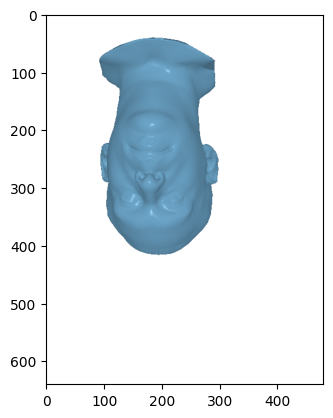

In [72]:
img = 255*images.cpu().contiguous().numpy()
img = img.astype('uint8')
img = img[0, :, :, :3]
plt.imshow(img)

In [95]:
cv2.imwrite('test.png', img)

True

In [85]:
cv2.imwrite

<function imwrite>

In [261]:
    
# 读取二进制文件
with open('../training_data/000220.bin', 'rb') as f:
    # 读取数据
    data = f.read()

In [100]:
verts = mesh.verts_packed()

In [129]:
verts, faces, aux = load_obj('../test_data/000220.obj')

/home/aaron/miniconda3/envs/mp/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [130]:
aux

Properties(normals=None, verts_uvs=tensor([[0.3518, 0.4916],
        [0.3586, 0.5064],
        [0.3471, 0.5128],
        ...,
        [0.6662, 0.6382],
        [0.6761, 0.6513],
        [0.6772, 0.6545]]), material_colors=None, texture_images=None, texture_atlas=None)

In [7]:
texture_image.expand((1, 1024, 1024, 3)).shape

torch.Size([1, 1024, 1024, 3])

In [ ]:
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

In [168]:
RR, TT = look_at_view_transform(3, 0, 180)

In [169]:
RR

tensor([[[ 1.0000e+00, -0.0000e+00,  8.7423e-08],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-8.7423e-08,  0.0000e+00,  1.0000e+00]]])

In [111]:
TT

tensor([[-0., -0., 3.]])

In [146]:
R

tensor([[[ 0.9759,  0.0040,  0.2182],
         [ 0.1042,  0.8698, -0.4822],
         [-0.1917,  0.4933,  0.8484]]])

In [42]:
cameras.in_ndc()

True

In [48]:
meshes.has_verts_normals()

True

In [46]:
def get_ndc_fcl_prp(Ks):
        ndc_fx = Ks[:, 0, 0] * 2 / 224.0
        ndc_fy = Ks[:, 1, 1] * 2 / 224.0
        ndc_px = - (Ks[:, 0, 2] - 112.0) * 2 / 224.0
        ndc_py = - (Ks[:, 1, 2] - 112.0) * 2 / 224.0
        focal_length = torch.stack([ndc_fx, ndc_fy], dim=-1)
        principal_point = torch.stack([ndc_px, ndc_py], dim=-1)
        return focal_length, principal_point

In [55]:
verts.shape

torch.Size([7306, 3])

In [56]:
torch.max(verts[:, 0])

tensor(118.0952, device='cuda:0')

In [60]:
verts[1, 0]

tensor(-18.8887, device='cuda:0')

In [61]:
verts[1][0]

tensor(-18.8887, device='cuda:0')

In [89]:
def get_ndc(verts, znear, zfar):
    
    xmax = torch.max(verts[:, 0])
    xmin = torch.min(verts[:, 0])
    
    ymax = torch.max(verts[:, 1])
    ymin = torch.min(verts[:, 1])
    
    zmax = torch.max(verts[:, 2])
    zmin = torch.min(verts[:, 2])
    
    # scale x, y value to range (-1, 1)
    verts[:, 0] = ((verts[:, 0] - xmin) / (xmax-xmin)) * 2 -1
    verts[:, 1] = ((verts[:, 1] - ymin) / (ymax-ymin)) * 2 -1
    # verts[:, 0] = ((verts[:, 0] - xmin) / (xmax-xmin))*2 - 1 
    # verts[:, 1] = ((verts[:, 1] - ymin) / (ymax-ymin))*2 - 1 
    
    # scale x value to given range (znear, zfar)
    verts[:, 2] = ((verts[:, 2] - zmin) / (zmax-zmin)) * (zfar - znear) + znear
    
    return verts
    
    

In [90]:
device='cuda:0'    
verts, faces, aux = load_obj('../test_data/000220.obj')


transform = [-0.6413242, 0.014517092, -0.76713264, 773.42,
-0.7567478, 0.15304689, 0.6355387, -645.5726,
0.12663344, 0.9881123, -0.0871669, 1268.4379]
transform = np.array(transform).reshape((3, 4))
R = transform[:3, :3]
t = transform[:, 3]
verts = ((R@verts.numpy().T).T + t)
verts = torch.tensor(verts)
verts_ndc = get_ndc(verts, 0, 100)

/home/aaron/miniconda3/envs/mp/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [91]:
torch.max(verts_ndc[: ,1])

tensor(1., dtype=torch.float64)

In [92]:
torch.min(verts_ndc[: ,1])


tensor(-1., dtype=torch.float64)

In [88]:
torch.max(verts_ndc[: ,2])

tensor(100., dtype=torch.float64)

In [199]:
focal[:, 0].shape

torch.Size([1])

In [178]:
verts, faces, aux = load_obj('../test_data/000220.obj')
verts[:, 0] *= -1
verts[:, 1] *= -1

In [218]:
import torch
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform,
    TexturesUV,
    FoVPerspectiveCameras,
    PointLights,
    MeshRenderer,
    RasterizationSettings,
    MeshRasterizer,
    SoftPhongShader,
    BlendParams,
    Textures,
    PerspectiveCameras

)
import cv2
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
from PIL import Image
from pytorch3d.io import load_objs_as_meshes, load_obj

device='cuda:0'    
verts, faces, aux = load_obj('../test_data/000220.obj')

# verts = verts * 0.001

verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)

texture_image = Image.open("../test_data/000220.png")
texture_image = texture_image.transpose(Image.FLIP_TOP_BOTTOM)
texture_image = np.array(texture_image)[::-1, :, :].copy()
texture_image = torch.from_numpy(texture_image).float() / 255.0
texture_image = texture_image.reshape((1, 1024, 1024, 3))

tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)

# transform world-coordinate to camera-coordinate
# transform = [-0.6413242, 0.014517092, -0.76713264, 773.42,
# -0.7567478, 0.15304689, 0.6355387, -645.5726,
# 0.12663344, 0.9881123, -0.0871669, 1268.4379]

transform = [0.9759047, 0.004041422, 0.21815981, -275.5805,
0.10419873, 0.86982536, -0.4822307, 456.9492,
-0.19170985, 0.49334317, 0.84844553, 191.94185]

transform = np.array(transform).reshape((3, 4))
R = transform[:3, :3]
t = transform[:, 3]
verts = torch.tensor(((R@verts.numpy().T).T + t), dtype=torch.float32)
# verts[:, 0] *= -1
# verts[:, 1] *= -1
print(verts)
# verts_ndc = get_ndc(verts, 0, 100)
# transform camera-coordinate to NDC-coordinate



meshes = Meshes(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=tex.to(device))

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!

# verts = meshes.verts_packed()
# N = verts.shape[0]
# center = verts.mean(0)
# scale = max((verts - center).abs().max(0)[0])
# meshes.offset_verts_(-center)
# meshes.scale_verts_((1.0 / float(scale)))

# 設置攝像機和照明

focal = torch.tensor([7702.4736, 7703.745], dtype=torch.float32).to(device).unsqueeze(0)
princpt = torch.tensor([801.6277, 997.59296], dtype=torch.float32).to(device).unsqueeze(0)

cameras = PerspectiveCameras(device=device, focal_length=-focal, principal_point=princpt, in_ndc=False, image_size=((2048, 1334),))
# cameras = PerspectiveCameras(device=device, focal_length=focal, principal_point=princpt)
raster_settings = RasterizationSettings(
            image_size=[2048, 1334],
            blur_radius=0.0,
            faces_per_pixel=1,
        )

lights = PointLights(device=device, location=[[0.0, 1.0, -10.0]])

with torch.no_grad():
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights
        )
    )
    images = renderer(meshes, znear=0.0, zfar=1500.0)



tensor([[-1.0186e+02,  2.3364e+01,  1.0915e+03],
        [-9.0880e+01,  8.9808e+01,  1.0311e+03],
        [-7.1771e+01,  9.3494e+01,  9.9381e+02],
        ...,
        [ 2.2884e+01,  7.7274e+01,  1.1640e+03],
        [ 1.2373e+01,  7.2082e+01,  1.1746e+03],
        [ 4.7402e-01,  6.8798e+01,  1.1844e+03]])


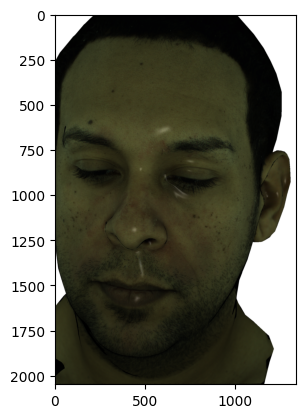

In [221]:
img = 255*images.cpu().contiguous().numpy()
img = img.astype('uint8')
img = img[0, :, :, :3]
cv2.imwrite('../test_data/test.png',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# img = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(img)

In [6]:
look_at_view_transform(2.5, 0, 180)

(tensor([[[ 1.0000e+00, -0.0000e+00,  8.7423e-08],
          [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
          [-8.7423e-08,  0.0000e+00,  1.0000e+00]]]),
 tensor([[-0.0000, -0.0000, 2.5000]]))

tensor([[-0.3888,  0.2065,  0.2429],
        [-0.2377,  0.3516, -0.1756],
        [-0.1021,  0.2733, -0.3271],
        ...,
        [ 0.1983,  0.6366,  0.5673],
        [ 0.1319,  0.6401,  0.6148],
        [ 0.0603,  0.6502,  0.6529]], device='cuda:0')


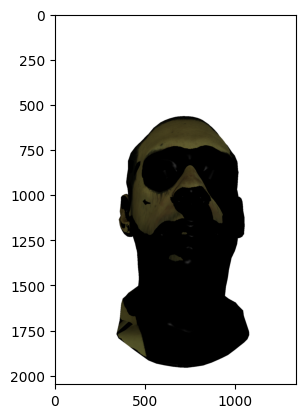

In [117]:
import torch
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform,
    TexturesUV,
    FoVPerspectiveCameras,
    PointLights,
    MeshRenderer,
    RasterizationSettings,
    MeshRasterizer,
    SoftPhongShader,
    BlendParams,
    Textures,
    PerspectiveCameras

)
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
from PIL import Image
from pytorch3d.io import load_objs_as_meshes, load_obj
import cv2
    
verts, faces, aux = load_obj('../test_data/000220.obj')
device='cuda:0'    
# verts = verts * 0.001

verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)

texture_image = Image.open("../test_data/000220.png")
texture_image = texture_image.transpose(Image.FLIP_TOP_BOTTOM)
texture_image = np.array(texture_image)[::-1, :, :].copy()
texture_image = torch.from_numpy(texture_image).float() / 255.0
texture_image = texture_image.reshape((1, 1024, 1024, 3))

tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)

meshes = Meshes(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=tex.to(device))

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = meshes.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
meshes.offset_verts_(-center)
meshes.scale_verts_((1.0 / float(scale)))
print(meshes.verts_packed())
# 設置攝像機和照明
R, T = look_at_view_transform(2.5, 0, 180)
# R = [0.9759047, 0.004041422, 0.21815981,
# 0.10419873, 0.86982536, -0.4822307, 
# -0.19170985, 0.49334317, 0.84844553 ]

# T = [0, 0, 2.5]

# R = torch.tensor(R).reshape((1, 3, 3))
# T = torch.tensor(T).reshape((1, 3))
focal = torch.tensor([3.0], dtype=torch.float32).to(device)
princpt = torch.tensor([0.1, 0.1], dtype=torch.float32).to(device).unsqueeze(0)

cameras = PerspectiveCameras(device=device, focal_length=focal, R=R, T=T, principal_point=princpt)
raster_settings = RasterizationSettings(
            image_size=[2048, 1334],
            blur_radius=0.0,
            faces_per_pixel=1,
 
        )

lights = PointLights(device=device, location=[[0.0, 0.0, -10.0]])

with torch.no_grad():
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights
        )
    )
    images = renderer(meshes)
    
img = 255*images.cpu().contiguous().numpy()
img = img.astype('uint8')
img = img[0, :, :, :3]
img = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(img)

In [157]:
meshes.verts_packed()

tensor([[-0.3888,  0.2065,  0.2429],
        [-0.2377,  0.3516, -0.1756],
        [-0.1021,  0.2733, -0.3271],
        ...,
        [ 0.1983,  0.6366,  0.5673],
        [ 0.1319,  0.6401,  0.6148],
        [ 0.0603,  0.6502,  0.6529]], device='cuda:0')

In [155]:
verts

tensor([[ -48.1071,   67.3655, 1010.2392],
        [ -18.8887,   95.4126,  929.3578],
        [   7.3019,   80.2762,  900.0712],
        ...,
        [  65.3622,  150.5015, 1072.9222],
        [  52.5336,  151.1689, 1082.1195],
        [  38.6894,  153.1265, 1089.4698]], device='cuda:0')

In [179]:
subject = '6674443'
facial = 'E001_Neutral_Eyes_Open'
view = '400008'
idx = '000220'

with open(
        f'/home/aaron/Desktop/multiface/{subject}_GHS/geom/tracked_mesh/{facial}/{idx}.obj',
        'r') as f:
    total_lines = len(f.readlines())

print(total_lines)
txt = ''
with open(
        f'/home/aaron/Desktop/multiface/{subject}_GHS/geom/tracked_mesh/{facial}/{idx}.obj',
        'r') as f:
    for i in range(7306):
        f.readline()
        txt += f'v {verts[i][0]} {verts[i][1]} {verts[i][2]}\n'
    for _ in range(7306, total_lines):

        txt += f.readline()

with open('../test_data/test.obj', 'w') as w:
    w.write(txt)

51050
